# A Practical Implementation of the Faster R-CNN Algorithm for Object Detection

## Blood Cell Detection Problem

### Link Tutorial: [Faster R-CNN tutorial](https://www.analyticsvidhya.com/blog/2018/11/implementation-faster-r-cnn-python-object-detection/)

### Link Dataset: [BCCD_dataset](https://github.com/Shenggan/BCCD_Dataset)

#### Changing keras version (needed to train successfully)

In [0]:
# Verifying keras version
import keras

print(keras.__version__)

Using TensorFlow backend.


2.2.0


In [0]:
# Changing keras version to 2.2.0
!pip install q keras==2.2.0

    100% |████████████████████████████████| 307kB 8.9MB/s 
    100% |████████████████████████████████| 51kB 15.9MB/s 
tensorflow 1.13.0rc0 has requirement keras-applications>=1.0.6, but you'll have keras-applications 1.0.2 which is incompatible.
tensorflow 1.13.0rc0 has requirement keras-preprocessing>=1.0.5, but you'll have keras-preprocessing 1.0.1 which is incompatible.
  Found existing installation: Keras-Applications 1.0.7
    Uninstalling Keras-Applications-1.0.7:
      Successfully uninstalled Keras-Applications-1.0.7
  Found existing installation: Keras-Preprocessing 1.0.8
    Uninstalling Keras-Preprocessing-1.0.8:
      Successfully uninstalled Keras-Preprocessing-1.0.8
  Found existing installation: Keras 2.2.4
    Uninstalling Keras-2.2.4:
      Successfully uninstalled Keras-2.2.4


## 1 - Downloading and Extracting Dataset

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount("/content/drive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import zipfile

local_zip = '/content/drive/My Drive/BCCD_Dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

## 2 - Creating csv file

In [0]:
%pylab inline

import os, sys, random
import xml.etree.ElementTree as ET
from glob import glob
import pandas as pd
from shutil import copyfile

DATA_DIR = "/tmp/BCCD_Dataset/"

annotations = glob(DATA_DIR + 'BCCD/Annotations/*.xml')

df = []

print(len(annotations))

for file in annotations:
  prev_filename = file.split('/')[-1].split('.')[0] + '.jpg'
  filename = file.split('/')[-1].split('.')[0] + '.jpg'
  row = []
  parsedXML = ET.parse(file)
  for node in parsedXML.getroot().iter('object'):
    blood_cells = node.find('name').text
    xmin = int(node.find('bndbox/xmin').text)
    xmax = int(node.find('bndbox/xmax').text)
    ymin = int(node.find('bndbox/ymin').text)
    ymax = int(node.find('bndbox/ymax').text)

    row = [prev_filename, filename, blood_cells, xmin, xmax, ymin, ymax]
    df.append(row)

data = pd.DataFrame(df, columns=['prev_filename', 'filename', 'cell_type',
'xmin', 'xmax', 'ymin', 'ymax'])

data[['filename', 'cell_type', 'xmin', 'xmax', 'ymin', 'ymax']].to_csv(
    DATA_DIR + 'blood_cell_detection.csv', index=False)

Populating the interactive namespace from numpy and matplotlib
364


## 3 - Visualizing Data

In [0]:
# importing required libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import patches

# read the csv file using read_csv function of pandas

data = pd.read_csv(DATA_DIR + 'blood_cell_detection.csv')
data.head()

,filename,cell_type,xmin,xmax,ymin,ymax
0,BloodImage_00333.jpg,RBC,183,260,144,287
1,BloodImage_00333.jpg,RBC,129,249,40,141
2,BloodImage_00333.jpg,RBC,86,181,153,244
3,BloodImage_00333.jpg,RBC,56,164,233,332
4,BloodImage_00333.jpg,RBC,205,319,313,425


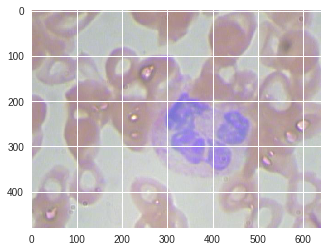

In [0]:
# reading single image using imread function of matplotlib

image = plt.imread(DATA_DIR + 'BCCD/JPEGImages/BloodImage_00000.jpg')
plt.imshow(image)

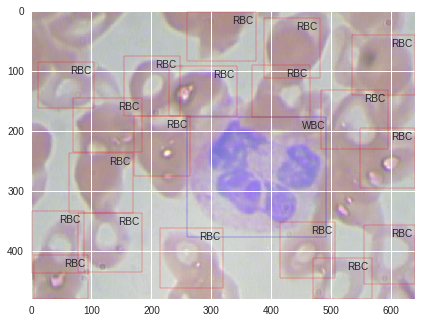

In [0]:
fig = plt.figure()

#add axes to the image
ax = fig.add_axes([0,0,1,1])

# read and plot the image
image = plt.imread(DATA_DIR + 'BCCD/JPEGImages/BloodImage_00000.jpg')
plt.imshow(image)

# iterating over the image for different objects
for _,row in data[data.filename == "BloodImage_00000.jpg"].iterrows():
    xmin = row.xmin
    xmax = row.xmax
    ymin = row.ymin
    ymax = row.ymax
    
    width = xmax - xmin
    height = ymax - ymin
    
    # assign different color to different classes of objects
    if row.cell_type == 'RBC':
        edgecolor = 'r'
        ax.annotate('RBC', xy=(xmax-40,ymin+20))
    elif row.cell_type == 'WBC':
        edgecolor = 'b'
        ax.annotate('WBC', xy=(xmax-40,ymin+20))
    elif row.cell_type == 'Platelets':
        edgecolor = 'g'
        ax.annotate('Platelets', xy=(xmax-40,ymin+20))
        
    # add bounding boxes to the image
    rect = patches.Rectangle((xmin,ymin), width, height, edgecolor = edgecolor, facecolor = 'none')
    
    ax.add_patch(rect)

## 4 - Splitting Data into Training and Test

### Splitting Images

In [0]:
import os
import numpy as np
import shutil

# Creating Train / Test folders
root_dir = '/tmp/BCCD_Dataset'
images_dir = '/tmp/BCCD_Dataset/BCCD/JPEGImages'
train_dir = root_dir +'/train'
test_dir = root_dir +'/test'

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)

# Loading images
images = glob(images_dir + '/*.jpg')

number_images = len(images)

# Creating dict (index, image)
index = 0
dict_images = {}

for file in images:
  dict_images[index] = file.split('/')[-1].split('.')[0] + '.jpg'
  index += 1

# Spliting into training and test 
numbers_list = np.arange(number_images)
np.random.shuffle(numbers_list)
images_train_index = numbers_list[:int(number_images * 0.8)]
images_test_index = numbers_list[int(number_images * 0.8):]

# Copying images into your respective folder
for item in images_train_index:
  shutil.copy((images_dir + '/' + dict_images[item]), train_dir)
  
for item in images_test_index:
  shutil.copy((images_dir + '/' + dict_images[item]), test_dir)
  
print('Total images: ', number_images)
print('Number of training images: ', len(images_train_index))
print('Number of test images: ', len(images_test_index))

Total images:  364
Number of training images:  291
Number of test images:  73


### Creating Training CSV file

In [0]:
# Creating csv file for training data

train_df = []

for item in images_train_index:
  for _,row in data[data.filename == dict_images[item]].iterrows():
    train_df.append(row)
    
train = pd.DataFrame(train_df, columns=['filename', 'cell_type',
'xmin', 'xmax', 'ymin', 'ymax']).to_csv(DATA_DIR + 'train.csv', index=False)

In [0]:
train = pd.read_csv(DATA_DIR + 'train.csv')
train.head()

,filename,cell_type,xmin,xmax,ymin,ymax
0,BloodImage_00387.jpg,RBC,54,161,262,385
1,BloodImage_00387.jpg,RBC,278,385,49,172
2,BloodImage_00387.jpg,RBC,149,283,159,258
3,BloodImage_00387.jpg,RBC,456,553,215,315
4,BloodImage_00387.jpg,RBC,508,605,149,249


In [0]:
# Number of unique training images
train['filename'].nunique()

291

In [0]:
# Number of classes
train['cell_type'].value_counts()

RBC          3313
WBC           297
Platelets     287
Name: cell_type, dtype: int64

## 5 - Implementing Faster R-CNN

### Clone [keras-frcnn](https://github.com/kbardool/keras-frcnn)

In [0]:
!git clone https://github.com/kbardool/keras-frcnn.git

Cloning into 'keras-frcnn'...
remote: Enumerating objects: 578, done.
remote: Total 578 (delta 0), reused 0 (delta 0), pack-reused 578
Receiving objects: 100% (578/578), 175.06 KiB | 3.43 MiB/s, done.
Resolving deltas: 100% (389/389), done.


### Moving test and train folders and train.csv to keras-frcnn folder

In [0]:
# Moving folders to keras-frcnn folder

final_dir = "/content/keras-frcnn"
train_dir = "/tmp/BCCD_Dataset/train"
test_dir = "/tmp/BCCD_Dataset/test"
csv_dir = "/tmp/BCCD_Dataset/train.csv"

if os.path.exists(final_dir + '/train'):
    shutil.rmtree(final_dir + '/train')
shutil.move(train_dir, final_dir)

if os.path.exists(final_dir + '/test'):
    shutil.rmtree(final_dir + '/test')
shutil.move(test_dir, final_dir)

shutil.move(csv_dir, final_dir)


'/content/keras-frcnn/train.csv'

### Converting CSV file to TXT file

#### Input format: filepath,x1,y1,x2,y2,class_name

In [0]:
# Creating a new DataFrame

data = pd.DataFrame()
data['format'] = train['filename']

# as the images are in train folder, add train folder's path before the image name
for i in range(data.shape[0]):
    data['format'][i] = '/content/keras-frcnn/train/' + data['format'][i]

# add xmin, ymin, xmax, ymax and class as per the format required
for i in range(data.shape[0]):
    data['format'][i] = data['format'][i] + ',' + str(train['xmin'][i]) + ',' + str(train['ymin'][i]) + ',' + str(train['xmax'][i]) + ',' + str(train['ymax'][i]) + ',' + train['cell_type'][i]

data.to_csv('/content/keras-frcnn/annotate.txt', header=None, index=None, sep=' ')

### Visualizing new file

In [0]:
txt_file = pd.read_csv('/content/keras-frcnn/annotate.txt')
print(txt_file)

      /content/keras-frcnn/train/BloodImage_00387.jpg   54  262  161  385  \
0     /content/keras-frcnn/train/BloodImage_00387.jpg  278   49  385  172   
1     /content/keras-frcnn/train/BloodImage_00387.jpg  149  159  283  258   
2     /content/keras-frcnn/train/BloodImage_00387.jpg  456  215  553  315   
3     /content/keras-frcnn/train/BloodImage_00387.jpg  508  149  605  249   
4     /content/keras-frcnn/train/BloodImage_00387.jpg  438   17  540  147   
5     /content/keras-frcnn/train/BloodImage_00387.jpg    1   71  113  196   
6     /content/keras-frcnn/train/BloodImage_00387.jpg   64    1  168   94   
7     /content/keras-frcnn/train/BloodImage_00387.jpg  543   65  640  165   
8     /content/keras-frcnn/train/BloodImage_00387.jpg  543  258  640  364   
9     /content/keras-frcnn/train/BloodImage_00387.jpg  202  236  430  478   
10    /content/keras-frcnn/train/BloodImage_00387.jpg  167  355  206  391   
11    /content/keras-frcnn/train/BloodImage_00387.jpg   62  177  115  224   

### Training the model

In [0]:
!python "/content/keras-frcnn/train_frcnn.py" -o simple -p "/content/keras-frcnn/annotate.txt"

Using TensorFlow backend.
Parsing annotation files
Training images per class:
{'Platelets': 287, 'RBC': 3313, 'WBC': 297, 'bg': 0}
Num classes (including bg) = 4
Config has been written to config.pickle, and can be loaded when testing to ensure correct results
Num train samples 239
Num val samples 52
Instructions for updating:
Colocations handled automatically by placer.
loading weights from resnet50_weights_tf_dim_ordering_tf_kernels.h5
Could not load pretrained model weights. Weights can be found in the keras application folder 		https://github.com/fchollet/keras/tree/master/keras/applications
Starting training
Epoch 1/2000
2019-02-05 01:32:28.930388: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300000000 Hz
2019-02-05 01:32:28.934454: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x2d1c840 executing computations on platform Host. Devices:
2019-02-05 01:32:28.934514: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device

### Testing a trained model

In [0]:
# Changed test_frcnn.py file and upload again
shutil.move("/test_frcnn.py", "/content/keras-frcnn")

'/content/keras-frcnn/test_frcnn.py'

In [0]:
# Moving the trained model after uploaded on Drive
shutil.move("/content/drive/My Drive/model_frcnn.hdf5", "/content/keras-frcnn")

'/content/keras-frcnn/model_frcnn.hdf5'

In [0]:
!python "/content/keras-frcnn/test_frcnn.py" -p "/content/keras-frcnn/test"

Using TensorFlow backend.
{0: 'RBC', 1: 'WBC', 2: 'Platelets', 3: 'bg'}
Instructions for updating:
Colocations handled automatically by placer.
Loading weights from /content/keras-frcnn/model_frcnn.hdf5
2019-02-05 01:49:24.817167: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300000000 Hz
2019-02-05 01:49:24.817418: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x8716b00 executing computations on platform Host. Devices:
2019-02-05 01:49:24.817450: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>
BloodImage_00003.jpg
Elapsed time = 11.705597639083862
[('WBC', 94.28160786628723), ('RBC', 99.08279180526733), ('RBC', 97.65045642852783), ('RBC', 96.20856046676636), ('RBC', 95.31323909759521), ('RBC', 94.87165808677673), ('RBC', 94.47741508483887), ('RBC', 93.57428550720215), ('RBC', 93.12655329704285), ('RBC', 92.2369122505188), ('RBC', 89.79628086090088), ('RBC', 83.99123549461365), ('RBC', 8